In [4]:
%matplotlib inline

import os
import sys
import shap
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as itl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import clone
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from time import time
from datetime import datetime, timedelta
#from typing import Dict, List, Tuple, Any, Union, Optional

shap.initjs()

In [5]:
from cancer_package import preprocessing, constants, transformers, utilities
import cancer_package.reporters as reporters

In [6]:
NON_NAN_THRESH = .7
REPLACE_BY_NAN = False
N_FOLDS = 10

In [7]:
results_dirs = {
    "xgb_binary_energy": {
        "dir": "./results/xgb_binary_energy_20210324_1159",
        "info": {"multiple_categories": False, "use_energy_proteins": True}
    },
    "xgb_multi_energy": {
        "dir": "./results/xgb_multi_energy_20210326_0845",
        "info": {"multiple_categories": True, "use_energy_proteins": True}
    },
    "xgb_binary_no_energy": {
        "dir": "./results/xgb_binary_no_energy_20210327_1624",
        "info": {"multiple_categories": False, "use_energy_proteins": False}
    },
    "xgb_multi_no_energy": {
        "dir": "./results/xgb_multi_no_energy_20210327_0037",
        "info": {"multiple_categories": True, "use_energy_proteins": False}
    }
}

====== xgb_binary_energy =======
rm 22 proteins with no data


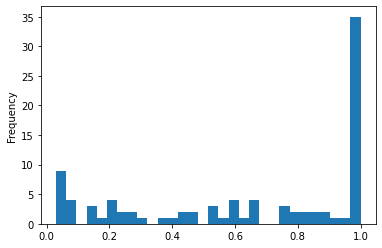

verification the transformation went fine
{0: 'cancer', 1: 'non-cancer'}
====== xgb_multi_energy =======
rm 22 proteins with no data


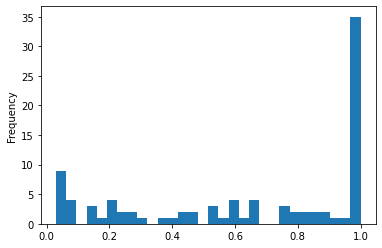

verification the transformation went fine
{1: 'CCA', 5: 'GC', 2: 'CRC', 7: 'LD', 3: 'CTL', 0: 'BC', 6: 'LC', 4: 'EC'}
====== xgb_binary_no_energy =======
rm 22 proteins with no data
rm 28 energy proteins


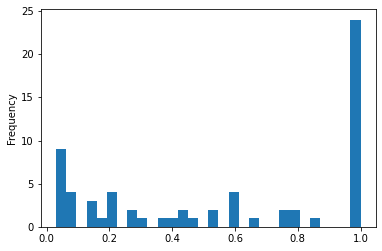

verification the transformation went fine
{0: 'cancer', 1: 'non-cancer'}
====== xgb_multi_no_energy =======
rm 22 proteins with no data
rm 28 energy proteins


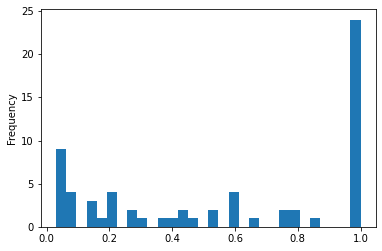

verification the transformation went fine
{1: 'CCA', 5: 'GC', 2: 'CRC', 7: 'LD', 3: 'CTL', 0: 'BC', 6: 'LC', 4: 'EC'}


In [8]:
DATA = {}
MODEL_RESULTS = {}

for name, results_path in results_dirs.items():
    print(f"====== {name} =======")
    MODEL_RESULTS[name] = joblib.load(os.path.join(results_path["dir"], "model.pkl"))
    
    use_energy_proteins = results_path["info"]["use_energy_proteins"]
    multiple_categories = results_path["info"]["multiple_categories"]
    
    data = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))

    data_prep = preprocessing.BasicPreprocessing(data, constants.NA_VALUE, use_energy_proteins)
    data_prep.organise_proteins(protein_group)
    data_prep.non_nan_share_hist(bins=30)
    data_prep.bio_features(formulas_df)
    data_prep.rm_execess_nans(NON_NAN_THRESH, by_group=False)

    DATA[name] = {}
    DATA[name]["clean_equations_mapping"] = data_prep.clean_equation_mapping
    data = shuffle(data_prep.data, random_state=69)
    DATA[name]["data"] = data
    DATA[name]["proteins"] = data_prep.proteins
    DATA[name]["formulas_df"] = data_prep.formulas_df
    feature_names = data_prep.feature_names()

    X, y = data[feature_names], data["category"]

    if multiple_categories:
        category_mapping = {('LD (COPD)', 'LD (PM)'): "LD"}
    else:
        category_mapping = {
            ('CTL', 'LD (COPD)', 'LD (PM)'): "non-cancer",
            ('GC', 'LC', 'CCA', 'CRC', 'BC', 'EC'): "cancer"
        }
    category_encoder = transformers.MapCategories( category_mapping)
    y = category_encoder.fit_transform(y)
    DATA[name]["category_encoder"] = category_encoder

    if REPLACE_BY_NAN:
        X.fillna(constants.NA_VALUE, inplace=True)
    
    DATA[name]["X"] = X
    DATA[name]["y"] = y

    print("verification the transformation went fine")
    print({i:category_encoder.inverse_transform(pd.Series([i]))[0] for i in y.unique()})
    category_encoder.inverse_transform( y).value_counts() / len(y)

CLEAN_EQUATION_MAPPING = DATA["xgb_multi_no_energy"]["clean_equations_mapping"]

In [9]:
best_features = {
    name: results["fs_features"][results["fs_scores"].idxmax()] 
    for name, results in MODEL_RESULTS.items()
}

#best_features

In [10]:
# accuracy and balanced accuracy for trivial estimator
from sklearn.metrics import balanced_accuracy_score

print(
    balanced_accuracy_score(
        DATA["xgb_binary_no_energy"]["y"],
        np.zeros_like(y),
        sample_weight=utilities.class_weights(DATA[name]["y"])
    )
)

from sklearn.metrics import accuracy_score
accuracy_score(
    DATA["xgb_binary_no_energy"]["y"],
    np.zeros_like(y),
    #sample_weight=utilities.class_weights(DATA[name]["y"])
)

0.5


0.683982683982684

In [11]:
MODEL_RESULTS['xgb_binary_energy']["fs_scores"]# == model_results['xgb_binary_energy']["fs_scores"].max()

225   -0.288608
224   -0.291560
223   -0.301077
219   -0.282847
217   -0.294645
dtype: float64

In [12]:
{name: len(features) for name, features in best_features.items()}

{'xgb_binary_energy': 219,
 'xgb_multi_energy': 75,
 'xgb_binary_no_energy': 26,
 'xgb_multi_no_energy': 45}

# Reporters



============  xgb_binary_energy  ================
1: 219
2: 219



cv f1-macro 83.29%
cv f1-micro 85.71%
cv accuracy score for best tree: 85.71%
cv balanced accuracy for best tree: 82.92%
cv confusion


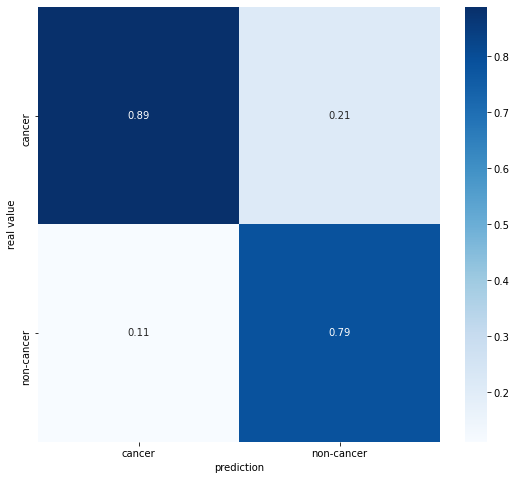

              precision    recall  f1-score   support

      cancer       0.89      0.91      0.90       158
  non-cancer       0.79      0.75      0.77        73

    accuracy                           0.86       231
   macro avg       0.84      0.83      0.83       231
weighted avg       0.86      0.86      0.86       231

recall by category


,category,recall
3,CTL,0.727273
8,LD (PM),0.739130
5,GC,0.765957
7,LD (COPD),0.823529
2,CRC,0.909091
0,BC,0.941176
1,CCA,0.960000
4,EC,1.000000
6,LC,1.000000




decision tree feature importance


,name,importance
0,DNAJ / HSP90,4.27%
1,HSP90AA1 / TRAP1,4.26%
2,HSP90AB1 / TRAP1,4.11%
3,HSPA9 * STUB1,3.74%
4,ST13 / HSPA4,3.44%
5,HSPB1 * ST13,3.04%
6,GSR / HSPB1,2.93%
7,HSPA6 / TRAP1,2.66%
8,HSPA8 / HSPD1,2.57%
9,ST13 / HSPH1,2.39%


importance of each individual feature (ordered)


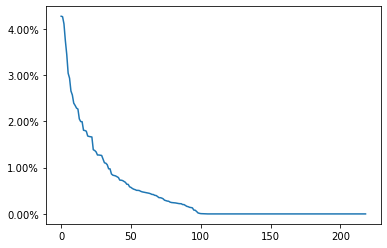

cumulative importance of each feature (ordered)


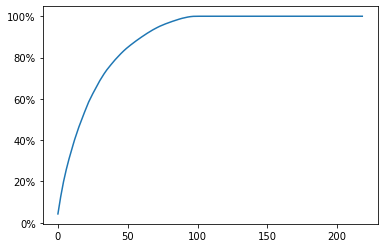



============  xgb_multi_energy  ================
1: 75
2: 75



cv f1-macro 58.19%
cv f1-micro 61.04%
cv accuracy score for best tree: 61.04%
cv balanced accuracy for best tree: 57.62%
cv confusion


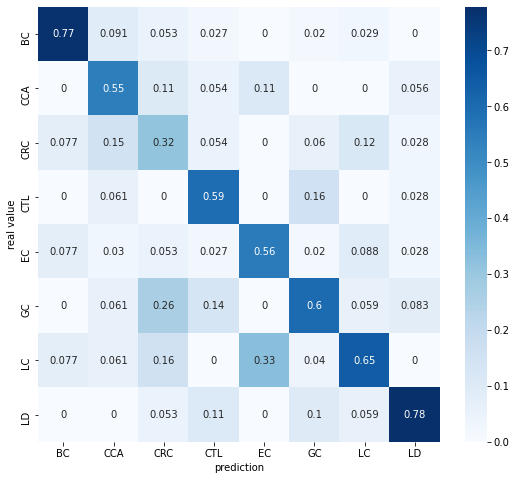

              precision    recall  f1-score   support

          BC       0.77      0.59      0.67        17
         CCA       0.55      0.72      0.62        25
         CRC       0.32      0.27      0.29        22
         CTL       0.59      0.67      0.63        33
          EC       0.56      0.36      0.43        14
          GC       0.60      0.64      0.62        47
          LC       0.65      0.67      0.66        33
          LD       0.78      0.70      0.74        40

    accuracy                           0.61       231
   macro avg       0.60      0.58      0.58       231
weighted avg       0.61      0.61      0.61       231

recall by category


,category,recall
2,CRC,0.272727
4,EC,0.357143
0,BC,0.588235
5,GC,0.638298
3,CTL,0.666667
6,LC,0.666667
8,LD (PM),0.695652
7,LD (COPD),0.705882
1,CCA,0.720000




decision tree feature importance


,name,importance
0,PPP5C / HSP90AA1,4.20%
1,HSPA9 * ST13,3.08%
2,GSR / HSP90AB1,2.76%
3,ST13 / STIP1,2.73%
4,FBP1,2.68%
5,HSPA8 / HSPA9,2.57%
6,(CCT1 + CCT2 + CCT6A) / HSP90AB1,2.53%
7,HSPA12A / HSP90B1,2.46%
8,HSPA8 * ST13,2.26%
9,(GSTA1 + GSTA2) / (HSP90 + HSPB1),2.25%


importance of each individual feature (ordered)


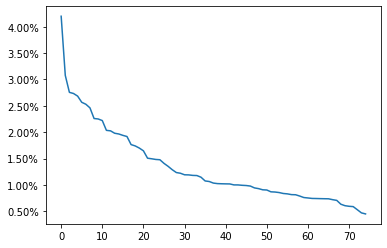

cumulative importance of each feature (ordered)


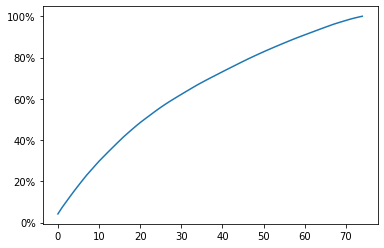



============  xgb_binary_no_energy  ================
1: 26
2: 26



cv f1-macro 84.87%
cv f1-micro 87.01%
cv accuracy score for best tree: 87.01%
cv balanced accuracy for best tree: 84.61%
cv confusion


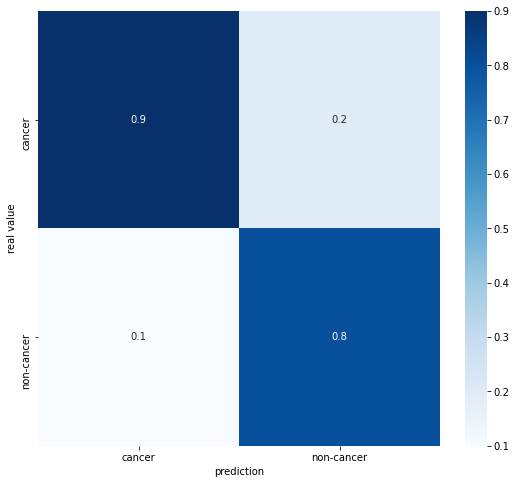

              precision    recall  f1-score   support

      cancer       0.90      0.91      0.91       158
  non-cancer       0.80      0.78      0.79        73

    accuracy                           0.87       231
   macro avg       0.85      0.85      0.85       231
weighted avg       0.87      0.87      0.87       231

recall by category


,category,recall
3,CTL,0.727273
8,LD (PM),0.782609
1,CCA,0.800000
4,EC,0.857143
7,LD (COPD),0.882353
5,GC,0.893617
0,BC,0.941176
2,CRC,0.954545
6,LC,1.000000




decision tree feature importance


,name,importance
0,HSP90AB1 / TRAP1,14.74%
1,HSPA6 / TRAP1,7.50%
2,HSP90AA1 / TRAP1,6.91%
3,DNAJA1 * DNAJA2 * DNAJC11 * DNAJB1 * DNAJC5 * DNAJC13,6.36%
4,HSPB1 * HSPA9,5.99%
5,HSP70 / DNAJ,5.23%
6,CCT2 / HSP90AB1,4.97%
7,HSPA6 * STIP1,4.21%
8,HSPA8 * TRAP1,3.94%
9,(CCT3 + CCT8) / HSP90AA1,3.63%


importance of each individual feature (ordered)


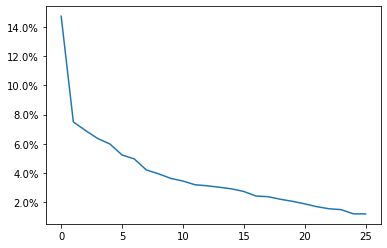

cumulative importance of each feature (ordered)


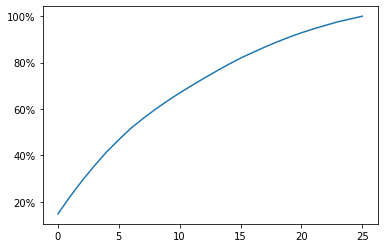



============  xgb_multi_no_energy  ================
1: 45
2: 45



cv f1-macro 48.02%
cv f1-micro 51.52%
cv accuracy score for best tree: 51.52%
cv balanced accuracy for best tree: 47.46%
cv confusion


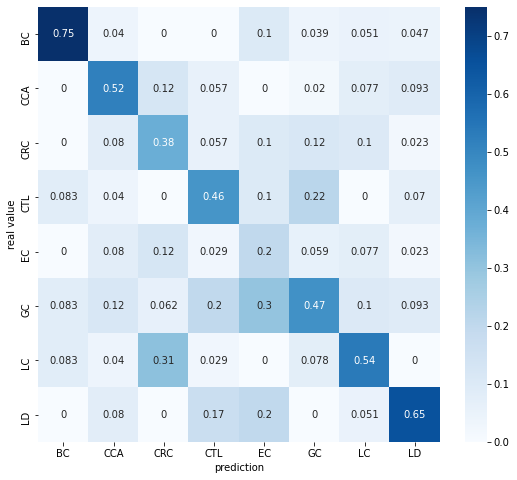

              precision    recall  f1-score   support

          BC       0.75      0.53      0.62        17
         CCA       0.52      0.52      0.52        25
         CRC       0.38      0.27      0.32        22
         CTL       0.46      0.48      0.47        33
          EC       0.20      0.14      0.17        14
          GC       0.47      0.51      0.49        47
          LC       0.54      0.64      0.58        33
          LD       0.65      0.70      0.67        40

    accuracy                           0.52       231
   macro avg       0.50      0.47      0.48       231
weighted avg       0.51      0.52      0.51       231

recall by category


,category,recall
4,EC,0.142857
2,CRC,0.272727
3,CTL,0.484848
5,GC,0.510638
1,CCA,0.520000
0,BC,0.529412
6,LC,0.636364
8,LD (PM),0.652174
7,LD (COPD),0.764706




decision tree feature importance


,name,importance
0,DNAJA1 * DNAJA2 * DNAJC11 * DNAJB1 * DNAJC5 * DNAJC13,4.21%
1,(CCT1 + CCT2 + CCT6A) / HSP90AA1,3.73%
2,(CCT1 + CCT2 + CCT6A) / HSP90AB1,3.27%
3,CCT2 / HSP90AB1,3.26%
4,PPP5C / HSP90AA1,3.17%
5,HSPA6 / TRAP1,3.15%
6,HSPB1 * HSPA6,2.80%
7,FKBP4 / HSP90AA1,2.78%
8,HSP90AA1 / TRAP1,2.78%
9,HSP90AB1 / HSP90B1,2.70%


importance of each individual feature (ordered)


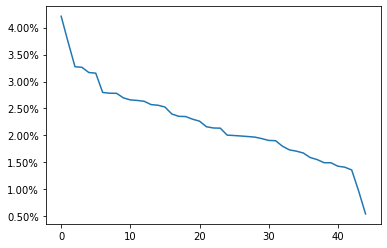

cumulative importance of each feature (ordered)


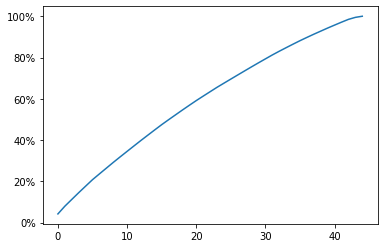

In [13]:
#import seaborn as sns
#sns.set(font_scale=2)

cv_splitter = StratifiedKFold(N_FOLDS, shuffle=False)

for name in DATA.keys():
    print(f"\n\n============  {name}  ================")
    best_score_idx = MODEL_RESULTS[name]["fs_scores"].idxmax()
    best_pipe = MODEL_RESULTS[name]["fs_pipes"][best_score_idx]
    best_features = MODEL_RESULTS[name]["fs_features"][best_score_idx]

    xgb_feat_imp = reporters.report_maker(
        best_pipe,
        DATA[name]["X"][best_features],
        DATA[name]["y"],
        X_test=None,
        y_test=None,
        category_names=DATA[name]["category_encoder"].classes_.tolist(),
        categories=data.category.to_list(),
        feature_codes=best_features.tolist(),
        equation_mapping=DATA[name]["clean_equations_mapping"],
        weight_array=utilities.class_weights(DATA[name]["y"]),
        cv=cv_splitter
    )

# Analysing which proteins are in model (directly or indirectly)

In [ ]:
"""
dummy_data = pd.DataFrame({'patient_id':[1,11], 'category':[2,22], "a":[3,33]})
formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))

data_prep = preprocessing.BasicPreprocessing(dummy_data, constants.NA_VALUE)
data_prep.bio_feature_equations(formulas_df)
"""

In [ ]:
def get_proteins_in_features(feature_names, feature_mapping):
    clean_feature_names = pd.Series(feature_names).apply(lambda x: feature_mapping.get(x, x))
    proteins_in_features = itl.chain(*clean_feature_names.str.findall(r'\w+').tolist())
    return  np.unique(list(proteins_in_features))

proteins_in_features = {}
for name, features in best_features.items():
    proteins_in_features[name] = get_proteins_in_features(
        features,
        data_prep.clean_equation_mapping
    )

In [ ]:
proteins_in_features_df = pd.concat(
    [
        pd.Series(len(proteins)*[1], index=proteins, name=name)
        for name, proteins in proteins_in_features.items()
        if name != 'xgb_binary_energy'
    ],
    axis="columns"
).fillna(0)
# .style.format(lambda x: True if x else False)

proteins_in_features_df.sort_values(["xgb_multi_energy", "xgb_multi_no_energy", "xgb_binary_no_energy"], ascending=False)

In [ ]:
proteins_in_features_df[~proteins_in_features_df.index.isin(constants.ENERGY_PROTEINS)].sum(1).value_counts()

# SHAP

In [ ]:
#! pip install shap==0.39

In [14]:
def logloss(true_label, predicted, n_classes, eps=1e-15):
    dummy = np.repeat(0, n_classes)
    dummy[true_label] = 1
    return log_loss(dummy, predicted)

In [15]:
def best_worst_preds(model, X, y, category_encoder, cv):
    n_categories = len(category_encoder.classes_)
    y_pred_prob = cross_val_predict(clone(model), X, y, cv=cv, method='predict_proba')

    pred_prob_df = pd.DataFrame(
        y_pred_prob,
        columns=category_encoder.classes_,
        index=y.index
    )
    pred_prob_df["y_pred"] = pred_prob_df.idxmax(1)
    pred_prob_df["y_code"] = y
    pred_prob_df["y"] = category_encoder.inverse_transform(y)
    pred_prob_df["correct_pred"] = pred_prob_df["y"] == pred_prob_df["y_pred"]
    pred_prob_df["log_loss"] = pred_prob_df.apply(
        lambda row: logloss(row["y_code"], row[category_encoder.classes_], n_categories),
        axis=1
    )

    return pred_prob_df.drop("y_code", axis=1)

In [128]:
SHAP_DIR = os.path.join(os.getcwd(), "result_plots")

def display_force_plot_and_comments(
        explainer,
        shap_values,
        X_patient,
        performance_info,
        category_encoder,
        save_name):
    n_classes = len(category_encoder.classes_)
    # predict proba case
    y_patient = performance_info['y']
    y_pred_patient = performance_info['y_pred']
    if n_classes > 0: #n_classes > 2:
        y_code = category_encoder.transform(pd.Series(y_patient))[0]
        y_pred_code = category_encoder.transform(pd.Series(y_pred_patient))[0]
        exp_value = explainer.expected_value
    else:
        y_pred_code = 0
        exp_value = [explainer.expected_value]
    print(f"y == {y_patient}, y_code == {y_code}")
    print(f"y_pred == {y_pred_patient}, y_code == {y_pred_code}")

    if performance_info["correct_pred"]:
        print(
            f"model correctly predicted {y_patient} (p={performance_info[y_patient]:.2%})",
            f" -- log loss {performance_info['log_loss']:.3}"
        )
    else:
        print(
            f"model predicted {y_pred_patient} (p={performance_info[y_pred_patient]:.2%}) ", 
            f"when in fact it was {y_patient} (p={performance_info[y_patient]:.2%}) ",
            f"-- log loss {performance_info['log_loss']:.3}"
        )
        print("SHAP - prediction made (wrong category)")

    print(np.around(shap_values[y_pred_code], decimals=2))
    display(
        shap.force_plot(
            np.around(exp_value[y_pred_code], decimals=2),
            # predict proba case
            np.around(shap_values[y_pred_code], decimals=2), #shap_values[y_pred_code,:],
            X_patient.rename(columns=CLEAN_EQUATION_MAPPING).round(2),
            matplotlib=True,
            show=False if save_name else True,
            text_rotation=25
        )
    )
    if save_name:
        plt.savefig(
            os.path.join(SHAP_DIR, save_name, f"shap_force_actual_y_{y_patient}_pred_{y_pred_patient}.png")
        )
    
    if not performance_info["correct_pred"] and n_classes > 2:
        print("SHAP - prediction not made (correct category)")
        display(
            shap.force_plot(
                np.around(exp_value[y_code], decimals=2),
                # predict proba case
                np.around(shap_values[y_code], decimals=2), #shap_values[y_pred_code,:],
                X_patient.rename(columns=CLEAN_EQUATION_MAPPING).round(2),
                matplotlib=True,
                show=False if save_name else True,
                text_rotation=25
            )
        )
    
    if save_name:
        plt.savefig(
            os.path.join(SHAP_DIR, save_name, f"shap_force_actual_y_{y_patient}_pred_{y_pred_patient}.png")
        )

        
def best_worst_force_plots(best_model, X, y, best_worst, category_encoder, cv, save_name):
    for row_id, row in best_worst.iterrows():
        print(f"row_id {row_id}")
        X_patient = X.loc[[row_id]]
        row_number = X.index.get_loc(row_id)
        train_rownum, test_rownum = [
            (train_rownum, test_rownum) for train_rownum, test_rownum 
            in cv_splitter.split(DATA[name]["X"], DATA[name]["y"])
            if row_number in test_rownum
        ][0]
        
        model = clone(best_model).fit(X.iloc[train_rownum], y.iloc[train_rownum]) 
        explainer = shap.TreeExplainer(model, data=X, model_output='predict_proba')
        shap_values = explainer.shap_values(X_patient)
        
        display_force_plot_and_comments(explainer, shap_values, X_patient, row, category_encoder, save_name)

row_id 127
y == cancer, y_code == 0
y_pred == cancer, y_code == 0
model correctly predicted cancer (p=99.85%)  -- log loss 0.00147
[[ 0.01  0.    0.    0.    0.02  0.   -0.    0.04  0.01  0.01  0.01  0.
   0.05  0.01  0.01  0.03  0.    0.04 -0.    0.01  0.05 -0.   -0.01  0.01
   0.   -0.  ]]


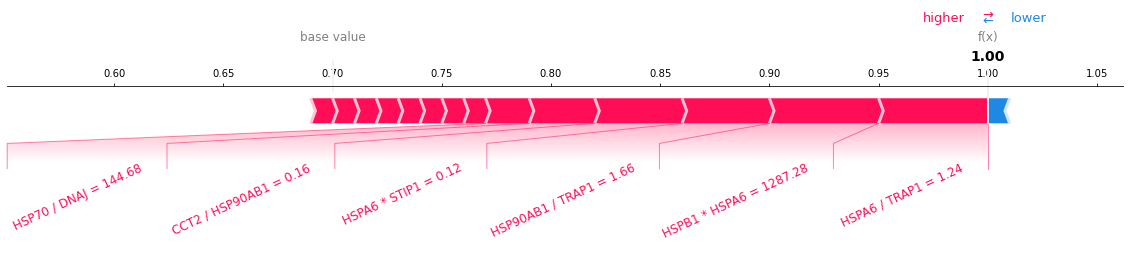

row_id 188
y == cancer, y_code == 0
y_pred == non-cancer, y_code == 1
model predicted non-cancer (p=88.02%)  when in fact it was cancer (p=11.98%)  -- log loss 2.12
SHAP - prediction made (wrong category)
[[ 0.01  0.02  0.01 -0.02  0.09 -0.    0.02  0.13  0.04  0.02  0.07 -0.02
   0.1   0.02  0.04 -0.08 -0.   -0.02 -0.   -0.01  0.01  0.07  0.04 -0.01
   0.03  0.03]]


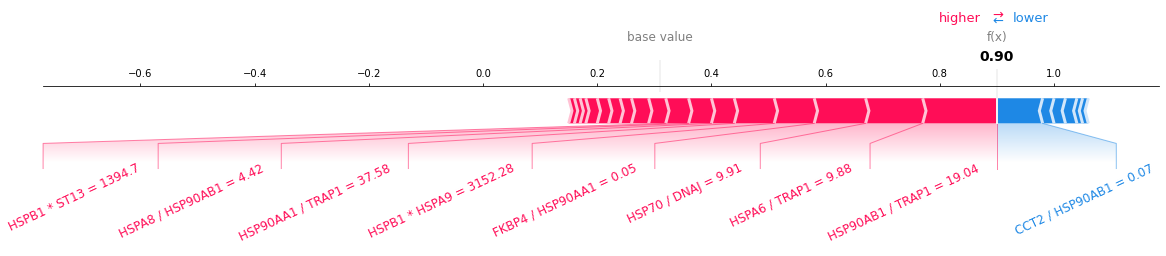

row_id 206
y == non-cancer, y_code == 1
y_pred == non-cancer, y_code == 1
model correctly predicted non-cancer (p=99.43%)  -- log loss 0.00576
[[ 0.01  0.01  0.01 -0.01  0.08 -0.    0.04  0.15  0.03  0.01  0.04  0.03
   0.06  0.03  0.02  0.06 -0.    0.01  0.02  0.01  0.01  0.04  0.02 -0.01
  -0.    0.03]]


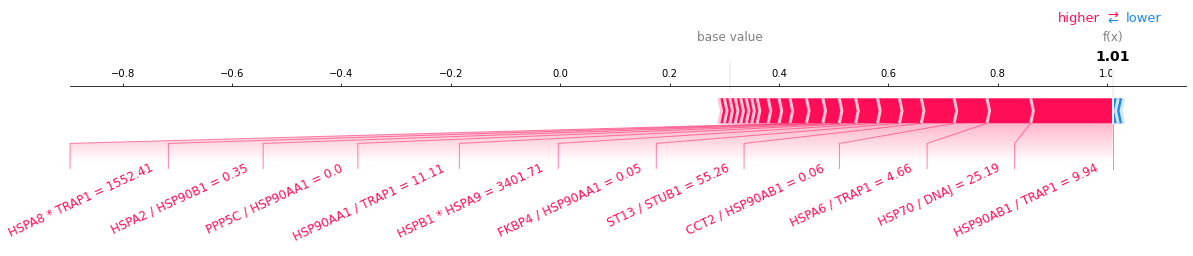

row_id 7
y == non-cancer, y_code == 1
y_pred == cancer, y_code == 0
model predicted cancer (p=98.87%)  when in fact it was non-cancer (p=1.13%)  -- log loss 4.48
SHAP - prediction made (wrong category)
[[-0.01  0.    0.    0.    0.03  0.   -0.01  0.    0.03  0.01 -0.    0.01
   0.05 -0.   -0.01 -0.02  0.   -0.   -0.   -0.   -0.    0.1   0.05  0.03
   0.01  0.02]]


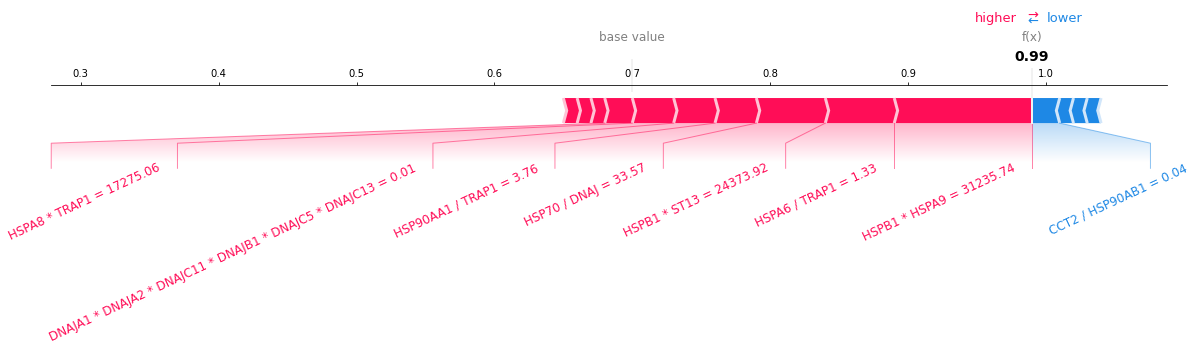

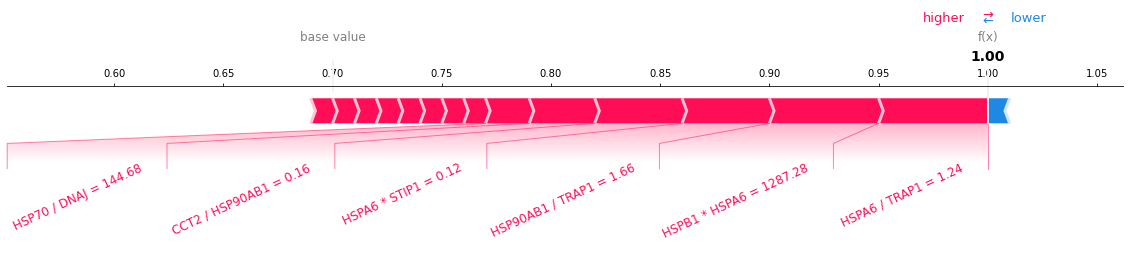

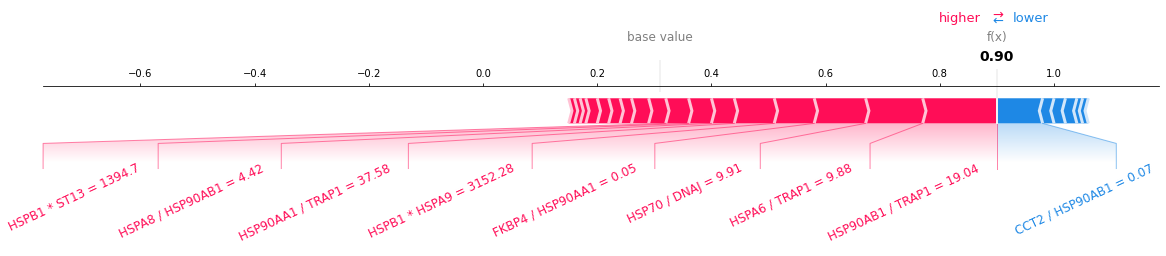

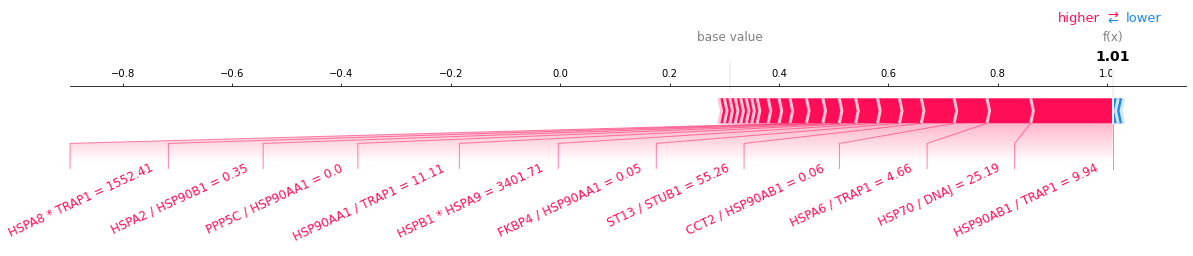

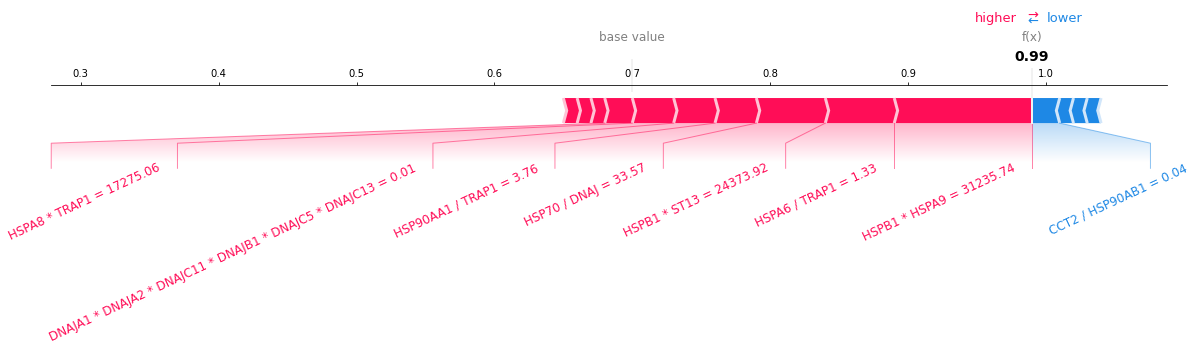

In [129]:
name = "xgb_binary_no_energy" # "xgb_multi_no_energy" #
selected_model_results = MODEL_RESULTS[name] 
best_score_idx = selected_model_results["fs_scores"].idxmax()
best_features = selected_model_results["fs_features"][best_score_idx]
best_model = selected_model_results["fs_pipes"][best_score_idx]["model"]

best_worst_df = best_worst_preds(
    best_model,
    DATA[name]["X"][best_features],
    DATA[name]["y"],
    DATA[name]["category_encoder"],
    cv_splitter
)

best_worst_by_category = (
    best_worst_df
    .groupby("y")
    .apply(lambda df: df.sort_values("log_loss").iloc[[0, -1]])
    .reset_index("y",drop=True)
)

best_worst_force_plots(
    best_model,
    DATA[name]["X"][best_features],
    DATA[name]["y"],
    best_worst_by_category,
    DATA[name]["category_encoder"],
    cv_splitter,
    save_name=name
)

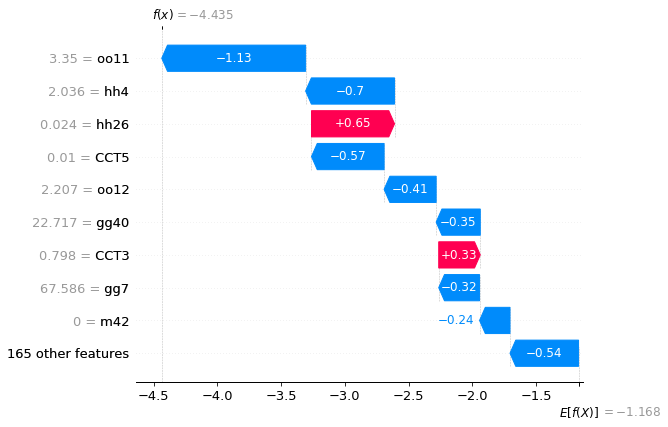

In [56]:
#explainer = shap.Explainer(clone(best_model).fit(DATA[name]["X"], DATA[name]["y"]))
#shap_values = explainer(DATA[name]["X"])
#shap.plots.waterfall(shap_values[0])

In [ ]:
display_waterfall_shap(
    best_worst_df.sort_values("log_loss").iloc[[0,-1]],
    DATA[name]
)

In [44]:
shap_values[0]

array([ 0.00882887,  0.00886856, -0.11261767, -0.0179699 , -0.05782849,
        0.02182056, -0.01552989, -0.13306622, -0.04860877, -0.05153325,
       -0.06782678, -0.06749157, -0.03974225, -0.02014502,  0.01058826,
        0.14978346,  0.02729568, -0.02733383,  0.00832342, -0.0139818 ,
        0.08538915,  0.00908348, -0.06964312, -0.02859926, -0.075418  ,
        0.00500137])

In [34]:
shap_values = explainer.shap_values(DATA[name]["X"][best_features].iloc[0,:].values.reshape(1, -1))



model correctly predicted cancer (p=99.94%) -- log loss 0.000619


model predicted cancer (p=99.06%)  when in fact it was non-cancer (p=0.94%)  -- log loss 4.67
SHAP - pred made (wrong category)


In [ ]:
explainer.expected_value